## Import all the required Packages and library

In [108]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

##  Image Path for loading the Images



In [109]:
CurrentDirectory=os.getcwd()
imagePath = CurrentDirectory+'/data/2d_images/'
maskPath = CurrentDirectory+'/data/2d_masks/'
height, width = 256, 256
SEED=42

## Create the data vector of the Images 

In [110]:
all_images = [x for x in sorted(os.listdir(imagePath)) if x[-4:] == '.tif']

x_data = np.empty((len(all_images), height, width), dtype='float32')

for i, name in enumerate(all_images):
    im = cv2.imread(imagePath + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(width, height), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

y_data = np.empty((len(all_images), height, width), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(maskPath + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(width, height), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im

In [111]:
print(x_data.shape)
print(y_data.shape)

(267, 256, 256)
(267, 256, 256)


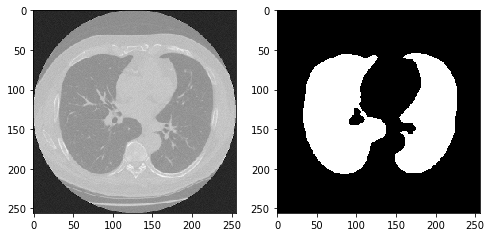

In [112]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[10], cmap='gray')
ax[1].imshow(y_data[10], cmap='gray')
plt.show()

In [113]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
print(x_data.shape)
print(y_data.shape)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.5)
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
shape=x_train.shape[1:]

(267, 256, 256, 1)
(267, 256, 256, 1)
(133, 256, 256, 1)
(134, 256, 256, 1)
(133, 256, 256, 1)
(134, 256, 256, 1)


In [114]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [115]:
input_layer = Input(shape=x_train.shape[1:])

conv_1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
maxpool = MaxPool2D(strides=(2,2))(conv_1)

conv_2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(maxpool)
maxpool = MaxPool2D(strides=(2,2))(conv_2)

conv_3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(maxpool)
maxpool = MaxPool2D(strides=(2,2))(conv_3)

conv_4 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(maxpool)
maxpool = MaxPool2D(strides=(2,2))(conv_4)

conv_5 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(maxpool)

deconv = concatenate([UpSampling2D(size=(2,2))(conv_5), conv_4], axis=-1)
deconv = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(deconv)

deconv = concatenate([UpSampling2D(size=(2,2))(deconv), conv_3], axis=-1)
deconv = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(deconv)

deconv = concatenate([UpSampling2D(size=(2,2))(deconv), conv_2], axis=-1)
deconv = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(deconv)

deconv = concatenate([UpSampling2D(size=(2,2))(deconv), conv_1], axis=-1)
deconv = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(deconv)

deconv = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(deconv)

deconv= Dropout(0.5)(deconv)


output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(deconv)
                                                         
model = Model(input_layer, output_layer)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 256, 256, 8)  80          input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_45[0][0]                  
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 128, 128, 16) 1168        max_pooling2d_17[0][0]           
__________________________________________________________________________________________________
max_poolin

In [116]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

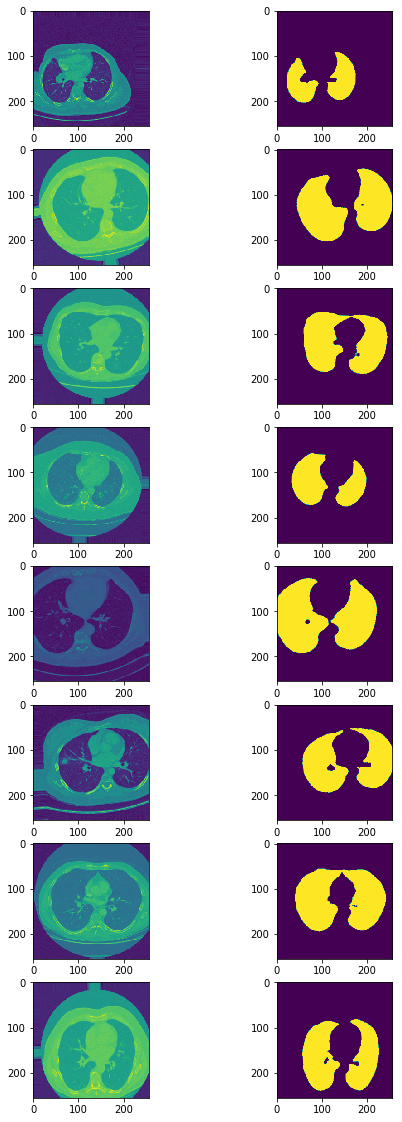

In [117]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [ ]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])
weight_saver = ModelCheckpoint('SavedModel.h5', monitor='val_dice_coef',save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [ ]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=20, verbose=1,
                           callbacks = [weight_saver, annealer])

Epoch 1/20
200/200 [==============================] - 18s 89ms/step - loss: 0.4735 - dice_coef: 0.3506 - val_loss: 0.2870 - val_dice_coef: 0.5385
Epoch 2/20
179/200 [=========================>....] - ETA: 1s - loss: 0.2500 - dice_coef: 0.6396

In [ ]:
model.load_weights('SavedModel.h5')

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid('on')
plt.show()

plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('Model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid('on')
plt.show()

In [ ]:
plt.figure()
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
ax[1].imshow(y_val[0,:,:,0], cmap='gray')
ax[2].imshow(y_hat[0,:,:,0], cmap='gray')

In [ ]:
from skimage.measure import label, regionprops
for i in range(5):
    prediction=model.predict(x_val[0].reshape(1,height, width, 1))
    image=prediction.reshape(height,width)
    print(image.dtype)
    image *= 255 # or any coefficient
    image = image.astype(np.uint8)
    ret3,image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    print(image.dtype)
    print(image)
    labelImage=label(image)
    regions=regionprops(labelImage)
    Area=[]
    for region in range(len(regions)):
        maxThreshold=regions[region].area
        Area.append(maxThreshold)
    print(Area)
    X= sorted( [(x,i) for (i,x) in enumerate(Area)], reverse=True )[:2]
    index=np.array(X)
    V=index.T[1].tolist()
    print((V[0]+1))  
    R=image.copy()
    L=image.copy()
    
    R[labelImage!=(V[1]+1)]=0
    L[labelImage!=(V[0]+1)]=0
    
    final=R+L
    
    plt.imshow(final,cmap='gray')